<a href="https://colab.research.google.com/github/Migaalee/machine_learning/blob/main/Assignment1_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project description
## Dataset 
The data set is inspired on the banknote authentication problem in the UCI machine learning repository, but the data was adapted for this assignment. The data are available on .tsv files where each line corresponds to a bank note and the five values, separated by commas, are, in order, the four features (variance, skewness and curtosis of Wavelet Transformed image and the entropy of the bank note image) and the class label, an integer with values 0 for real bank notes and 1 for fake bank notes.

## Objective
Parametrize, fit and compare Naive Bayes and Support Vector Machine classifiers using described dataset.

# Import all packages that will be used

In [1]:
# Numpy for data management
import numpy as np

# Pandas also for data management
import pandas as pd

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

import math

#ScikitLearn

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.neighbors import KernelDensity

from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

from sklearn.naive_bayes import GaussianNB

from google.colab import files #this is to load files from your local disk

from sklearn.svm import SVC

from sklearn import metrics

#from sklearn.svm import SVC #penso q faltava este??

#import McNemar

from sklearn.model_selection import GridSearchCV



# Upload data

Import training dataset

In [2]:
TP1_train = files.upload() 
 

Saving TP1_train.tsv to TP1_train.tsv


Import testing dataset

In [3]:
TP1_test = files.upload()

Saving TP1_test.tsv to TP1_test.tsv


# Data preparation

Read data, shuffle, standardize

In [4]:
# Read data
mat_train = np.loadtxt("TP1_train.tsv", delimiter="\t")
mat_test = np.loadtxt("TP1_test.tsv", delimiter="\t")
#print(mat_test)

# Shuffle data
data_train = shuffle(mat_train)
data_test = shuffle(mat_test)


# Standardize training dataset
Y_r = data_train[:,4] #classes
X_r = data_train[:,:4] #features
means_r = np.mean(X_r, axis = 0)
stdvs_r = np.std(X_r,axis = 0)
X_r = (X_r-means_r)/stdvs_r

# Standardize testing dataset
Y_t = data_test[:,4]
X_t = data_test[:,:4]
means_t = np.mean(X_t, axis = 0)
stdvs_t = np.std(X_t,axis = 0)
X_t = (X_t-means_t)/stdvs_t

 Naive Bayes



# Bayes classifiers

You must implement your own Naïve Bayes classifier using Kernel Density Estimation for the probability distributions of the feature values. For this, you can use any code from the lectures, lecture notes and tutorials that you find useful. Also, use the KernelDensity class from sklearn.neighbors.kde for the density estimation.

Use the same bandwidth value for all the Kernel Density Estimators in each instance of your Naïve Bayes classifier, and try values from 0.02 to 0.6 with a step of 0.02 for the bandwidth.
Use the default kernel ('gaussian') for the Kernel Density Estimators.

Funcao que calcula a prob de cada classe

In [130]:
def log_prob_classe(data): #equivale ao prior #data é o data set com as classes, para podermos calc as prob de cada classe
    classe1 = 0
    for value in data:
        value = int(value)
        if value == 1:
            classe1 += 1
    log_classe1 =  math.log( classe1 / len(data) )
    log_classe0 = math.log( 1 - classe1 / len(data) )
    return log_classe0, log_classe1 #retorna prob classe = 0, prob classe = 1

log_prob_r0, log_prob_r1 = log_prob_classe(Y_r)
log_prob_t0, log_prob_t1 = log_prob_classe(Y_t)

Funcao que separa os data sets por classe 

In [131]:
def sep_class(data_X, data_Y): #change to array?
    X0 = []
    X1 = []
 
    for i, value in enumerate(data_Y):
        value = int(value)
        if value == 0:
            X0 += [[data_X[i,0], data_X[i,1], data_X[i,2], data_X[i,3]]] #posso tentar fazer isto de uma forma mais bonitinha mas estava a dar arrays de outra forma portanto deixei assim por agora
        elif value == 1:
            X1 += [[data_X[i,0], data_X[i,1], data_X[i,2], data_X[i,3]]]
    return X0, X1

Xr_0, Xr_1 = sep_class(X_r, Y_r)
Xt_0, Xt_1 = sep_class(X_t, Y_t)

In [ ]:
# Esta tudo bem ate aqui
print(X_r)
print(Xr_0, Xr_1)

[[ 0.19274711 -0.60278663  0.49965436  0.53814392]
 [ 0.37388957 -0.40069342 -0.05874801  0.34621851]
 [-1.2911229   1.07690174 -0.72277378 -1.56438117]
 ...
 [-1.40348571 -1.41513897  1.22725441 -0.05137764]
 [ 1.98782804 -0.79380351  0.55108945  1.91165789]
 [ 0.84989927 -1.07840539  0.518176    1.14650166]]
[[-1.291122903700539, 1.0769017357263992, -0.7227737786785283, -1.5643811702625154], [-1.0371148657902012, 0.8578292515162206, -0.3465842826965223, -1.1418398084310335], [0.6170018207626419, 1.5501991160848108, 0.9544356774594768, 0.5055624167336359], [0.5815905125284929, 0.3897715702957454, -3.7106394528536417, -1.4803819838743293], [1.0521523200245877, 0.7906417170006557, 0.09242860882206601, 0.5997433226840265], [-1.1855699656949026, 1.043274805815845, -0.08615502749407582, -1.1708577091833159], [-0.7415666393744195, 0.6364353816120196, -0.7261527262472289, -1.0542770201960758], [-0.7170511182892394, 0.8295746713546899, -0.4841199633632637, -0.9692596618516691], [-0.0319785012

### Function for Naive Bayes (good one)

In [132]:
def fit_NBayes(X, Y, feat_matrix, bw):
    
    classes = np.zeros(feat_matrix.shape[0]) #make a matrix with zeros with shape of our dataset rows
    #X_0, X_1 = sep_class(X, Y)  #aqui chamamos a nossa funcao que separa as classes        


    X_0 = X[Y==0,:] #subset data based on classes, we get all features and class label 0
    X_1 = X[Y==1,:] #all features for class label 1


    # probabilities in ln to be able to sum later with score_samples, which are also in ln. Easier then multiplying probabilities without log  
    log_prob_r0, log_prob_r1 = log_prob_classe(Y_r) #aqui chamamos a funcao que da o log da probabilidade de classe


    for feature in range(0, X_0.shape[1]):        #for feature 1 to 4
        kde0 = KernelDensity(bandwidth=bw)  #should we use gaussian or other fit here? #kernel{‘gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}, default=’gaussian’
        kde0.fit(X_0[:,[feature]])
        log_prob_r0 += kde0.score_samples(feat_matrix[:, [feature]]) ####WORKING

    for feature in range(0, X_1.shape[1]):        
        kde1 = KernelDensity(bandwidth=bw)
        kde1.fit(X_1[:,[feature]])
        log_prob_r1 += kde1.score_samples(feat_matrix[:, [feature]])  ####WORKING

    for ix in range(0, np.shape(classes)[0]):
      if log_prob_r1[ix] > log_prob_r0[ix]:
        classes[ix] = 1
    
    return classes

a = fit_NBayes(X_r, Y_r, X_t,  0.02)
print(a)

[0. 1. 0. ... 0. 1. 1.]


Função para definir a melhor bandwidth

In [133]:
bandwidth_range = np.arange(0.02,0.61,0.02) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2

train_err=[]
valid_err=[]
folds = 5
kf = StratifiedKFold(n_splits=folds)

for bw in bandwidth_range:
  tr_err = va_err = 0

  for tr_ix,va_ix in kf.split(Y_r,Y_r):

    x_t = X_r[tr_ix]
    y_t = Y_r[tr_ix]
    x_v = X_r[va_ix]
    y_v = Y_r[va_ix]

    c_t = fit_NBayes(x_t, y_t, x_t, bw)  ##X, Y, bw, feat_matrix
    
    c_v = fit_NBayes(x_t, y_t, x_v, bw)

    nb_t_error = 1-metrics.accuracy_score(y_t, c_t) #calculate error with training set for that fold
    tr_err += nb_t_error


    nb_v_error = 1-metrics.accuracy_score(y_v, c_v) #calculate validation error for that fold with a validation dataset
    va_err += nb_v_error


    #r,v = calc_fold(feats,X_r,Y_r,tr_ix,va_ix)
    #tr_err += r
    #va_err += v

  train_err.append(tr_err/folds)
  valid_err.append(va_err/folds)
  print(str(np.round(bw,2)),':', tr_err/folds,va_err/folds)

0.02 : 0.03892359810354758 0.06821847389558233
0.04 : 0.050360317901495685 0.06259598393574295
0.06 : 0.05417336346388564 0.06179277108433734
0.08 : 0.055176976713272353 0.06098955823293173
0.1 : 0.05718339758230513 0.06098955823293171
0.12 : 0.05818620520195121 0.06500562248995982
0.14 : 0.058587610220218876 0.0642024096385542
0.16 : 0.05959082065473527 0.06339919678714859
0.18 : 0.06099523470008419 0.06259598393574298
0.2 : 0.061396236903481526 0.06259598393574298
0.22 : 0.06179764192174919 0.06098955823293173
0.24 : 0.06199804231973027 0.0625991967871486
0.26 : 0.06219864412514653 0.06179598393574297
0.28 : 0.06300125275424669 0.06259919678714858
0.3 : 0.06300165556911697 0.06179598393574297
0.32 : 0.0626004519582845 0.061799196787148604
0.34 : 0.0626004519582845 0.061799196787148604
0.36 : 0.06239985015286824 0.06420562248995984
0.38 : 0.06239985015286824 0.06420562248995984
0.4 : 0.0634032619948198 0.06420562248995984
0.42 : 0.06320266018940354 0.06420562248995984
0.44 : 0.0634034

Plot do gráfico para comparar o erro de teste e treino para diferentes bandwidh

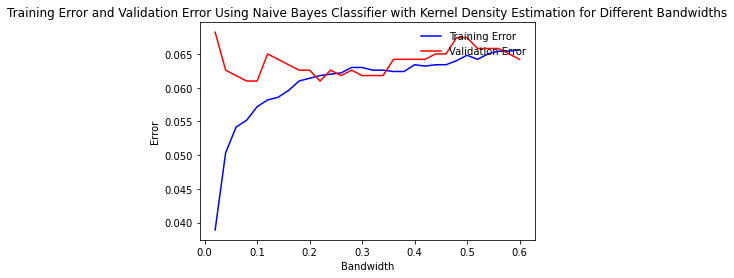

In [134]:
#PLOT DO ERRO DE TREINO E TESTE    
plt.plot(bandwidth_range, train_err,'b',label = 'Training Error') #o "b" é a cor
plt.plot(bandwidth_range,valid_err,'r',label = 'Validation Error')
plt.title('Training Error and Validation Error Using Naive Bayes Classifier with Kernel Density Estimation for Different Bandwidths') 
plt.xlabel('Bandwidth')
plt.ylabel('Error')
plt.legend(loc='upper right',frameon=False)
plt.show()
#plt.savefig('NB.png', dpi=300)
plt.close()
    

Show best bandwidth

In [135]:
print("smallest validation error is: "+ str(np.min(valid_err)))

#which corresponds to bandwidth: 
best_bw = bandwidth_range[np.argmin(valid_err)]
print("best bandwith is: ", best_bw)


smallest validation error is: 0.06098955823293171
best bandwith is:  0.1


Calculate True error with a test dataset

In [ ]:
bayes_full_training = fit_NBayes(X_r, Y_r, X_t, bw=best_bw)  ##X, Y, feat_matrix, best_bw
bayes_true_error= 1-metrics.accuracy_score(Y_t, bayes_full_training)
print ('Bayes true error is: ', np.round(bayes_true_error,6))

Bayes true error is:  0.106656


## Gaussian Bayes

In [136]:
NB_gaussian = GaussianNB() #criar o modelo do Naive Bayes usando Gaussiana
NB_gaussian.fit(X_r, Y_r) #usar os nossos dados de treino para fazer fit ao modelo
NB_gaussian_score = NB_gaussian.score(X_r, Y_r) #TODO confirmar q isto está bem!!! #aqui temos o score de avaliacao deste modelo

NB_gaussian_probs = NB_gaussian.predict_proba(X_t) #aqui podemos ver as probabilidades de ser classe 0 ou classe 1, sendo que a classe prevista é a q aumenta esta probabilidade
NB_gaussian_predict = NB_gaussian.predict(X_t) #aqui temos as previsoes do nosso modelo para o X de teste, podemos comparar estes resultados com o Y_t 

# SVM classifier

Notes: use a Support Vector Machine with a Gaussian radial basis function, available in the sklearn.svm.SVC class. Use a regularization factor C = 1 and optimize the gamma parameter with cross-validation on the training set. The SVM classifier you will use has two adjustable parameters, gamma and C. In this assignment we fixed parameter C at a value of 1 but you can try to improve the performance of this classifier by adjusting simultaneously these two parameters. This is an optional exercise, worth only 1/20 of the assignment grade: optimize both parameters, compare the optimized SVM with the previous classifiers and discuss whether this additional optimization was useful in this case. Use 5 folds for cross validation

##### Make a function to caculate best gamma



In [143]:
from sklearn.svm import SVC

gamma_range = np.arange(0.2,6.2,0.2) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2

train_err=[]
valid_err=[]
folds = 5
kf = StratifiedKFold(n_splits=folds)

for gamma in gamma_range:
  tr_err = va_err = 0

  for tr_ix,va_ix in kf.split(Y_r,Y_r):

    x_t = X_r[tr_ix]
    y_t = Y_r[tr_ix]
    x_v = X_r[va_ix]
    y_v = Y_r[va_ix]

    svm = SVC(C=1, gamma = gamma) 
    svm.fit(x_t,y_t) #re-fit all training data with training dataset


    svm_t_error = 1-svm.score(x_t,y_t) #calculate error with training set for that fold
    tr_err += svm_t_error


    svm_v_error = 1-svm.score(x_v,y_v) #calculate validation error for that fold with a validation dataset
    va_err += svm_v_error


    #r,v = calc_fold(feats,X_r,Y_r,tr_ix,va_ix)
    #tr_err += r
    #va_err += v

  train_err.append(tr_err/folds)
  valid_err.append(va_err/folds)
  print(str(np.round(gamma,2)),':', tr_err/folds,va_err/folds)

0.2 : 0.03370734694041966 0.0336995983935743
0.4 : 0.03069771563687047 0.03128995983935743
0.6 : 0.02949370198950265 0.03289317269076306
0.8 : 0.028289889749569985 0.03289317269076306
1.0 : 0.027286880722488728 0.03289317269076306
1.2 : 0.02588226526970472 0.03289317269076306
1.4 : 0.025080059455474847 0.03289317269076306
1.6 : 0.023675645410125967 0.03209317269076306
1.8 : 0.023274240391858325 0.03369638554216867
2.0 : 0.02347484219727458 0.03369638554216867
2.2 : 0.022271231364777065 0.03289638554216867
2.4 : 0.02207042815192566 0.03129317269076304
2.6 : 0.02207042815192568 0.03209638554216867
2.8 : 0.02186962493907425 0.03209638554216867
3.0 : 0.021267416707955178 0.03209638554216867
3.2 : 0.02026420627343879 0.03129638554216867
3.4 : 0.019863002662606277 0.030493172690763036
3.6 : 0.01946179905177379 0.030493172690763036
3.8 : 0.01946179905177379 0.03129638554216867
4.0 : 0.01946179905177379 0.03129638554216867
4.2 : 0.01885999363552504 0.03129638554216867
4.4 : 0.01906059544094129

##### Best gamma

In [139]:
print("smallest validation error is: "+ str(np.min(valid_err)))

best_g = gamma_range[np.argmin(valid_err)]

print("best gamma is: "+ str(best_g))

smallest validation error is: 0.030493172690763036
best gamma is: 3.4000000000000004


##### Now plot training and validation errors for different gamma

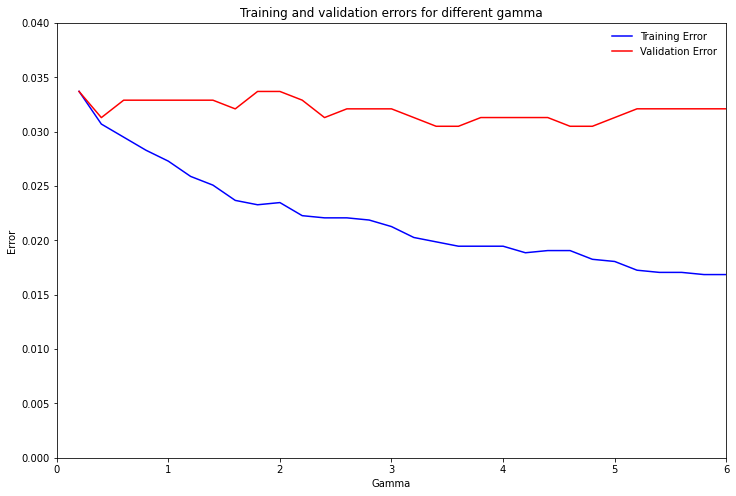

In [140]:
gamma_range = np.arange(0.2,6.2,0.2)
plt.figure(figsize=(12, 8))
plt.plot(gamma_range, train_err, c='b', label = 'Training Error')
plt.plot(gamma_range, valid_err, c='r', label = 'Validation Error')
plt.axis([0, 6,0.0,0.04])
plt.title('Training and validation errors for different gamma')
plt.xlabel('Gamma')
plt.ylabel('Error')
plt.legend(loc='upper right',frameon=False)
plt.show()
#plt.savefig('NB.png', dpi=300)
plt.close()


##### Best gamma for SVC is:

##### Calculate test error based on the model with best gamma

In [141]:
svm = SVC(C=1, gamma = best_g) #change gamma number here after
svm.fit(X_r,Y_r) #re-fit all training data with training dataset 
svm_true_error= 1 - svm.score(X_t, Y_t)
print ('SVM true error is: ', np.round(svm_true_error,6))

SVM true error is:  0.071371


# Optional task (best gamma and best penalty parameter in SVM)
##### We did optimisation using two different ways: A) using gridsearch, which is based on the best score AND B) using manually constructed grid and smallest validation error

### A)

In [175]:
from sklearn.svm import SVC

# Parameter space
gamma_range = list(np.arange(1,4,0.5)) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2
c_range = list(np.arange(0.5, 5, 0.5)) # To optimize penalty parameter
gamma_range = [round(num, 1) for num in gamma_range]
c_range = [round(num, 1) for num in c_range]

# Making a parameter dictionary to use in built-in python library

param_grid = {'C': c_range,
              'gamma': gamma_range}

svm_grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
svm_grid.fit(x_t,y_t) #re-fit all training data with training dataset


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] C=0.5, gamma=1.0 ................................................
[CV] .................... C=0.5, gamma=1.0, score=0.985, total=   0.0s
[CV] C=0.5, gamma=1.0 ................................................
[CV] .................... C=0.5, gamma=1.0, score=0.955, total=   0.0s
[CV] C=0.5, gamma=1.0 ................................................
[CV] .................... C=0.5, gamma=1.0, score=0.980, total=   0.0s
[CV] C=0.5, gamma=1.0 ................................................
[CV] .................... C=0.5, gamma=1.0, score=0.970, total=   0.0s
[CV] C=0.5, gamma=1.0 ................................................
[CV] .................... C=0.5, gamma=1.0, score=0.965, total=   0.0s
[CV] C=0.5, gamma=1.5 ................................................
[CV] .................... C=0.5, gamma=1.5, score=0.985, total=   0.0s
[CV] C=0.5, gamma=1.5 ................................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.5, gamma=2.5, score=0.985, total=   0.0s
[CV] C=0.5, gamma=2.5 ................................................
[CV] .................... C=0.5, gamma=2.5, score=0.955, total=   0.0s
[CV] C=0.5, gamma=2.5 ................................................
[CV] .................... C=0.5, gamma=2.5, score=0.985, total=   0.0s
[CV] C=0.5, gamma=2.5 ................................................
[CV] .................... C=0.5, gamma=2.5, score=0.970, total=   0.0s
[CV] C=0.5, gamma=2.5 ................................................
[CV] .................... C=0.5, gamma=2.5, score=0.960, total=   0.0s
[CV] C=0.5, gamma=3.0 ................................................
[CV] .................... C=0.5, gamma=3.0, score=0.985, total=   0.0s
[CV] C=0.5, gamma=3.0 ................................................
[CV] .................... C=0.5, gamma=3.0, score=0.955, total=   0.0s
[CV] C=0.5, gamma=3.0 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    4.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5],
                         'gamma': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

##### Print best gamma and best C parameter based on gridsearch method and best score

In [177]:
print("Best gamma and C parameters using gridsearch are: " + str(svm_grid.best_params_))

Best gamma and C parameters using gridsearch are: {'C': 1.5, 'gamma': 3.0}


### B)

In [192]:
from sklearn.svm import SVC
import itertools

# Define gamma and C range paramter space
gamma_range = np.arange(0.2,6.2,0.2) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2
c_range = np.arange(0.5, 5, 0.5)


# Make a grid with 
mesh = np.array(np.meshgrid(gamma_range, c_range)) #make a grid with both parameters
combinations = mesh.T.reshape(-1, 2) # this will result in all different combinations of parameters

# Export as two lists to use for iterations
g=list(combinations[:,0])
c=list(combinations[:,1])


train_err=[]
valid_err=[]
folds = 5
kf = StratifiedKFold(n_splits=folds)


for gamma, C in zip(g, c):

  tr_err = va_err = 0

  for tr_ix,va_ix in kf.split(Y_r,Y_r):

    x_t = X_r[tr_ix]
    y_t = Y_r[tr_ix]
    x_v = X_r[va_ix]
    y_v = Y_r[va_ix]

    svm = SVC(C=C, gamma = gamma) 
    svmfit = svm.fit(x_t,y_t) #re-fit all training data with training dataset


    svm_t_error = 1-svm.score(x_t,y_t) #calculate error with training set for that fold
    tr_err += svm_t_error


    svm_v_error = 1-svm.score(x_v,y_v) #calculate validation error for that fold with a validation dataset
    va_err += svm_v_error


    #r,v = calc_fold(feats,X_r,Y_r,tr_ix,va_ix)
    #tr_err += r
    #va_err += v

  train_err.append(tr_err/folds)
  valid_err.append(va_err/folds)
  print(str(np.round(gamma,2)),':', str(np.round(C,2)),':', tr_err/folds,va_err/folds)

0.2 : 0.5 : 0.035713767809452436 0.03690923694779118
0.2 : 1.0 : 0.03370734694041966 0.0336995983935743
0.2 : 1.5 : 0.032904939718754675 0.03450281124497993
0.2 : 2.0 : 0.03190132646936794 0.03450281124497993
0.2 : 2.5 : 0.03150012285853545 0.0336995983935743
0.2 : 3.0 : 0.03129972246055435 0.0328995983935743
0.2 : 3.5 : 0.030898317442286705 0.03370281124497994
0.2 : 4.0 : 0.030497113831454193 0.03209638554216867
0.2 : 4.5 : 0.030296310618602783 0.030489959839357428
0.4 : 0.5 : 0.031499921451100275 0.03289317269076306
0.4 : 1.0 : 0.03069771563687047 0.03128995983935743
0.4 : 1.5 : 0.029895107007770295 0.03128995983935745
0.4 : 2.0 : 0.028891896573253906 0.03208995983935745
0.4 : 2.5 : 0.028891896573253882 0.03208995983935745
0.4 : 3.0 : 0.028891896573253906 0.03208995983935745
0.4 : 3.5 : 0.028290091157005183 0.03289317269076306
0.4 : 4.0 : 0.028089489351588927 0.03289317269076306
0.4 : 4.5 : 0.028089489351588927 0.03289317269076306
0.6 : 0.5 : 0.030296310618602808 0.03209317269076306


##### Print best parameters (a combination of both)

In [194]:
print("smallest validation error is: "+ str(np.min(valid_err)))

best_g_b = g[np.argmin(valid_err)]
best_C_b = c[np.argmin(valid_err)]

print("best gamma is: "+ str(best_g_b))

print("best C is: "+ str(best_C_b))

smallest validation error is: 0.029686746987951797
best gamma is: 2.6000000000000005
best C is: 3.0


##### Estimate true error based on optimized C and gamma values

In [159]:
svm = SVC(C=best_C_b, gamma = best_g_b) #change gamma number here after
svm.fit(X_r,Y_r) #re-fit all training data with training dataset 
svm_true_error= 1 - svm.score(X_t, Y_t)
print ('SVM true error is: ', np.round(svm_true_error,6))

SVM true error is:  0.068164


# Comparison of classifiers

# For comparing the classifiers, we have used the approximate A) normal test and B) McNemar's test, both with a 95% confidence interval

##### Our classifiers

In [220]:
# Bayes models

naive_bayes = fit_NBayes(X_r, Y_r, X_t, bw=best_bw) # model 1
m1 = naive_bayes
gaussian_bayes =  NB_gaussian.predict(X_t) #model 2
m2=gaussian_bayes

# One parameter gamma optimization for SVM

svm_gamma_opt = SVC(C=1, gamma = best_g) 
svm_gamma_opt.fit(X_r,Y_r)
svm_gamma = svm_gamma_opt.predict(X_t) #model 3
m3=svm_gamma

# Two parameter optimization (gamma and C) for SVM using method A

svm_gamma_opt_a = SVC(C=1.5, gamma = 3) 
svm_gamma_opt_a.fit(X_r,Y_r)
svm_gamma_a = svm_gamma_opt_a.predict(X_t) #model 4
m4 = svm_gamma_a


# Two parameter optimization (gamma and C) for SVM using method B

svm_gamma_opt_b = SVC(C=3, gamma = 2.6) 
svm_gamma_opt_b.fit(X_r,Y_r)
svm_gamma_b = svm_gamma_opt_b.predict(X_t) #model 5
m5=svm_gamma_b




##### A) Approximate normal test

##### Just a quick look if data looks normal

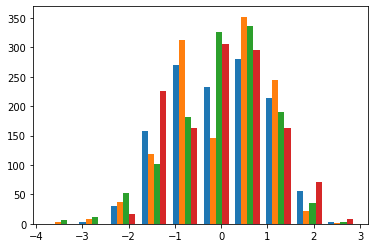

In [122]:
plt.hist(X_r) #check if training data looks approximately normal
plt.show()


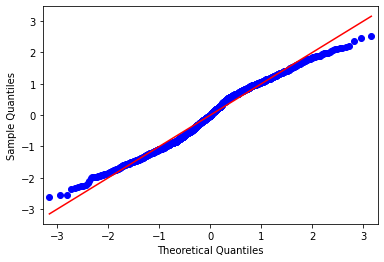

In [221]:
from statsmodels.graphics.gofplots import qqplot
qqplot(X_r[:,0], line='s')

plt.show()

In [223]:
import statistics as stats

def approx_normal(model):
    N = len(model)
    X=0
    for c in range(N):
        if model[c] != Y_t[c]:
            X+=1
            p=X/N
    stdev = np.sqrt(N*(X/N)*(1-(X/N)))
    return ("Mean is " + str(X) + " and confidence intervals are: " + str(1.96*stdev)) 

print("Naive Bayes: "+str(approx_normal(naive_bayes)))
print("Gaussian Bayes: "+str(approx_normal(gaussian_bayes)))
print("SVM with gamma optimisation: "+str(approx_normal(svm_gamma)))
print("SVM with gamma and C optimisation by method A: "+str(approx_normal(svm_gamma_a)))
print("SVM with gamma and C optimisation by method B: "+str(approx_normal(svm_gamma_b)))



Naive Bayes: Mean is 133 and confidence intervals are: 21.36442754661465
Gaussian Bayes: Mean is 186 and confidence intervals are: 24.656816817207723
SVM with gamma optimisation: Mean is 89 and confidence intervals are: 17.818540464422934
SVM with gamma and C optimisation by method A: Mean is 85 and confidence intervals are: 17.44356996487493
SVM with gamma and C optimisation by method B: Mean is 85 and confidence intervals are: 17.44356996487493


##### B) McNemar's test 

In [239]:
from mlxtend.evaluate import mcnemar_table

def mcnemars (model1, model2, classes):
  tb = mcnemar_table(y_target=classes, y_model1=model1, y_model2=model2)
  e01 = tb[0,1]
  e10 = tb[1,0]
  test = np.square(((abs(e01) - abs(e10))-1))/(e01 + e10)
  return("e01: " + str(e01) + " e10: " + str(e10) + " and test value: " + str(test))



In [240]:
print("Comparison between Naive Bayes with KDE and  Gaussian Bayes: " + str(mcnemars(m1, m2, Y_t)))
print("Comparison between Naive Bayes with KDE and  SVM (model3): " + str(mcnemars(m1, m3, Y_t)))
print("Comparison between Naive Bayes with KDE and  SVM (model4): : " + str(mcnemars(m1, m4, Y_t)))
print("Comparison between Naive Bayes with KDE and  SVM (model5): : " + str(mcnemars(m1, m5, Y_t)))
print("Comparison between SVM (model 3) and  SVM (model4): : " + str(mcnemars(m3, m4, Y_t)))
print("Comparison between SVM (model 3) and  SVM (model5): : " + str(mcnemars(m3, m5, Y_t)))
print("Comparison between SVM (model 4) and  SVM (model5): : " + str(mcnemars(m4, m5, Y_t)))

Comparison between Naive Bayes with KDE and  Gaussian Bayes: e01: 16 e10: 69 and test value: 34.305882352941175
Comparison between Naive Bayes with KDE and  SVM (model3): e01: 63 e10: 19 and test value: 22.548780487804876
Comparison between Naive Bayes with KDE and  SVM (model4): : e01: 63 e10: 15 and test value: 28.32051282051282
Comparison between Naive Bayes with KDE and  SVM (model5): : e01: 63 e10: 15 and test value: 28.32051282051282
Comparison between SVM (model 3) and  SVM (model4): : e01: 4 e10: 0 and test value: 2.25
Comparison between SVM (model 3) and  SVM (model5): : e01: 6 e10: 2 and test value: 1.125
Comparison between SVM (model 4) and  SVM (model5): : e01: 2 e10: 2 and test value: 0.25
